# Experiment for comparing topic modeling performance

In [1]:
import json
import csv
import os
from random import seed, shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

from octis.dataset.dataset import Dataset
from octis.models.model import AbstractModel
from octis.evaluation_metrics.metrics import AbstractMetric
from octis.models.CTM import CTM
from octis.models.LDA import LDA
from octis.evaluation_metrics.diversity_metrics import TopicDiversity, InvertedRBO
from octis.evaluation_metrics.coherence_metrics import Coherence, WECoherencePairwise, _load_default_texts

from experiments.utils import Top2Vec

## Define Python classes and functions

In [2]:
class BERTopic_octis(AbstractModel):
    def train_model(self, dataset, hyperparams={}, top_words=10):
        # Setting hyperparameters
        if "umap_args" in hyperparams:
            umap_model = UMAP(**hyperparams["umap_args"])
        else:
            umap_model = UMAP(
                n_neighbors=30, 
                n_components=2,
                min_dist=0.0,
                metric='cosine',
                random_state=1
        )
        if "hdbscan_args" in hyperparams:
            hdbscan_model = HDBSCAN(**hyperparams["hdbscan_args"])
        else:
            hdbscan_model = HDBSCAN(
                min_cluster_size=50, 
                metric='euclidean',
                prediction_data=True
            )
        if "vectorizer_args" in hyperparams:
            vectorizer_model = CountVectorizer(**hyperparams["vectorizer_args"])
            n_gram_range = hyperparams["vectorizer_args"].get(['ngram_range'], (1,1))
        else:
            vectorizer_model = CountVectorizer(
                ngram_range=(1, 1),
                stop_words="english"
            )
            n_gram_range = (1, 1)
        
        model = BERTopic(
            n_gram_range=n_gram_range,
            top_n_words=top_words,  # defines number of words per topic
            nr_topics=20,
            low_memory=True,
            embedding_model="sentence-transformers/msmarco-distilbert-base-v4",
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model
        )
        
        # Train the BERTopic model
        train_corpus, test_corpus = dataset.get_partitioned_corpus(use_validation=False)
        train_doc_topics, _ = model.fit_transform(list(map(lambda x: " ".join(x), train_corpus)))

        result = {
            'topics': [[word[0] for word in values] for _, values in model.topics.items()],
            'topic-word-matrix': model.c_tf_idf,
            'topic-document-matrix': np.array(train_doc_topics),  # in BERTopic a document only belongs to a topic
        }
        
        if len(test_corpus) > 0:
            # Transform on test corpus
            test_doc_topics, _ = model.transform(list(map(lambda x: " ".join(x), test_corpus)))
            result['test-topic-document-matrix'] = np.array(test_doc_topics)
        
        return result


class Top2Vec_octis(AbstractModel):
    def train_model(self, dataset, hyperparams={}, top_words=10):
        # Train the Top2Vec model
        train_corpus, test_corpus = dataset.get_partitioned_corpus(use_validation=False)
        model = Top2Vec(
            documents=list(map(lambda x: " ".join(x), train_corpus)), 
            **hyperparams
            )

        # Reduce the number of topics discovered by Top2Vec
        model.hierarchical_topic_reduction(20)
        model.get_topic_hierarchy()

        result = {
            'topics': [words[:10].tolist() for words in model.get_topics(20, reduced=True)[0]],
            'topic-word-matrix': np.inner(model.topic_vectors_reduced, model._get_word_vectors()),
            'topic-document-matrix': model.doc_top_reduced[:len(train_corpus)],  # in Top2Vec a document only belongs to a topic
        }

        if len(test_corpus) > 0:
            # Add test corpus - new document topics are appended to doc_top_reduced 
            model.add_documents(documents=list(map(lambda x: " ".join(x), test_corpus)))
            result['test-topic-document-matrix'] = model.doc_top_reduced[len(train_corpus):]
        
        return result


class OptMetric(AbstractMetric):
    def __init__(self, texts=None, topk=10):
        super().__init__()
        if texts is None:
            self._texts = _load_default_texts()
        else:
            self._texts = texts
        self.topk = topk

    def score(self, model_output):
        m1 = Coherence(texts=self._texts, topk=self.topk, measure='c_v')
        m2 = TopicDiversity(topk=self.topk)
        return m1.score(model_output) * m2.score(model_output)
        

def topic_evaluation(model_output, texts):
    """
    Provide a topic model output and get the score on several metrics.
    """
    output = {}

    # Topic Diversity
    metric = TopicDiversity(topk=10)
    output['topic_diversity'] = metric.score(model_output)

    # Topic Diversity - inverted RBO
    metric = InvertedRBO(topk=10)
    output['inverted_rbo'] = metric.score(model_output)

    # Topic Coherence - internal
    metric = Coherence(texts=texts, topk=10, measure='c_v')
    output['topic_coherence_c_v'] = metric.score(model_output)

    # Topic Coherence - external
    metric = WECoherencePairwise(topk=10)
    output['topic_coherence_we_coherence_pairwise'] = metric.score(model_output)

    return output

## Create the necessary data files

In [3]:
# Create the files for OCTIS
partition = False
if not os.path.exists("../../data/experiments/corpus.tsv"):
    # Open json backup file
    with open("../../data/backups/mongodb_cleaned_docs.json", "r") as file:
        jsondata = json.load(file)
        jsondata = jsondata[:10000]  # TODO: REMOVE THIS WHEN DOING THE REAL EVALUATION

    # Remove #SEPTAG# and get categ
    texts = list(map(lambda x: x['text'].replace("#SEPTAG#", " "), jsondata))
    categs = list(map(lambda x: x['meta']['category'], jsondata))

    # Write vocabulary file
    with open("../../data/experiments/vocabulary.txt", "w", newline='') as file:
        vectorizer = CountVectorizer(
            ngram_range=(1, 1),
            stop_words="english"
        )
        vectorizer.fit(texts)
        for i in vectorizer.vocabulary_.keys():
            file.writelines(i+'\n')

    # Write corpus file
    seed(1)
    rand_ix = list(range(len(texts)))
    shuffle(rand_ix)
    with open("../../data/experiments/corpus.tsv", "w", newline='') as file:
        csv_writer = csv.writer(file, delimiter="\t")
        for i, ix in enumerate(rand_ix):
            if partition:
                # 0.75 - 0.15 - 0.1 | train - val - test split
                if i < round(len(rand_ix)*0.75):
                    split = "train"
                elif i < round(len(rand_ix)*0.9):
                    split = "val"
                else:
                    split = "test"
            else:
                split = "train"
            csv_writer.writerow([texts[ix], split, categs[ix]])

## OCTIS : Optimizing and Comparing Topic Models is Simple!

### Loading the dataset

In [4]:
# Loading the dataset
dataset = Dataset()
dataset.load_custom_dataset_from_folder("../../data/experiments/")
train_docs = list(map(lambda x: " ".join(x), dataset.get_partitioned_corpus()[0]))

In [5]:
# Save topic model scores
topic_scores = {}

# Save document topics
doc_topics = {}

In [6]:
# Output folder
out_path = "../../outputs/experiments/"

### Topic Model Evaluation
We compare different topic models according to different metrics provided by the OCTIS package.

The models we compare are: LDA, Top2Vec and BERTopic

#### LDA

In [7]:
# Perform LDA
model = LDA(num_topics=20, random_state=2)  # Create model
model_output = model.train_model(dataset) # Train the model

# Save topic scores
topic_scores['LDA'] = topic_evaluation(model_output, dataset.get_corpus())

# Save document topics
doc_topics['LDA'] = np.argmax(model_output['topic-document-matrix'], axis=0)

#### BERTopic

In [8]:
# Preprocess the docs to match the topic words (necessary to evaluate Coherence)
prep = CountVectorizer(
    lowercase=True
).build_preprocessor()
prep_train_docs = list(map(lambda x: prep(x).split(" "), train_docs))

In [9]:
# Perform BERTopic
model = BERTopic_octis()  # Create model
model_output = model.train_model(
    dataset, 
    hyperparams={
        "umap_args": {
            "n_neighbors": 30, 
            "n_components": 10, 
            "min_dist": 0.0, 
            "metric": 'cosine', 
            "random_state":1
        },
        "hdbscan_args": {
            "min_cluster_size": 50, 
            "min_samples": 15,
            "cluster_selection_epsilon": 0.2,
            "metric": 'euclidean',
            "prediction_data": True
        }
    }
) # Train the model

# Save document topics
doc_topics['BERTopic'] = model_output['topic-document-matrix']

# What is the percentage of documents classified as noise?
perc_noise = 100 * (np.sum(doc_topics['BERTopic'] == -1) / doc_topics['BERTopic'].shape[0])
print(f"HDBSCAN classified {perc_noise}% of the observations as noise!")

HDBSCAN classified 23.39% of the observations as noise!


In [10]:
# Removing noisy documents from evaluation
noise_mask = (doc_topics['BERTopic'] != -1)
model_output['topics'] = model_output['topics'][1:]  # Evaluation only uses the "topics" output

# Save topic scores
topic_scores['BERTopic'] = topic_evaluation(model_output, np.array(prep_train_docs)[noise_mask])

#### Top2Vec with Doc2Vec

In [11]:
# Perform Top2Vec
model = Top2Vec_octis()  # Create model
model_output = model.train_model(
    dataset, 
    hyperparams={
        "embedding_model": "doc2vec",
        "umap_args": {
            "n_neighbors": 30, 
            "n_components": 10, 
            "min_dist": 0.0, 
            "metric": 'cosine', 
            "random_state":1
        },
        "hdbscan_args": {
            "min_cluster_size": 30, 
            "min_samples": 15,
            "cluster_selection_epsilon": 0.2,
            "metric": 'euclidean',
            "prediction_data": True
        }
    }
) # Train the model

# Save topic scores
topic_scores['Top2Vec_doc2vec'] = topic_evaluation(model_output, prep_train_docs)

# Save document topics
doc_topics['Top2Vec_doc2vec'] = model_output['topic-document-matrix']

2021-09-16 18:43:24,844 - top2vec - INFO - Pre-processing documents for training
2021-09-16 18:43:24,844 - top2vec - INFO - Pre-processing documents for training
2021-09-16 18:43:26,273 - top2vec - INFO - Creating joint document/word embedding
2021-09-16 18:43:26,273 - top2vec - INFO - Creating joint document/word embedding
2021-09-16 18:43:46,554 - top2vec - INFO - Creating lower dimension embedding of documents
2021-09-16 18:43:46,554 - top2vec - INFO - Creating lower dimension embedding of documents
2021-09-16 18:44:10,040 - top2vec - INFO - Finding dense areas of documents
2021-09-16 18:44:10,040 - top2vec - INFO - Finding dense areas of documents
2021-09-16 18:44:10,396 - top2vec - INFO - Finding topics
2021-09-16 18:44:10,396 - top2vec - INFO - Finding topics


#### Top2Vec with SBERT

In [12]:
# Perform Top2Vec
model = Top2Vec_octis()  # Create model
model_output = model.train_model(
    dataset, 
    hyperparams={
        "embedding_model": "sentence-transformers/msmarco-distilbert-base-v4",
        "umap_args": {
            "n_neighbors": 30, 
            "n_components": 10, 
            "min_dist": 0.0, 
            "metric": 'cosine', 
            "random_state":1
        },
        "hdbscan_args": {
            "min_cluster_size": 30, 
            "min_samples": 15,
            "cluster_selection_epsilon": 0.2,
            "metric": 'euclidean',
            "prediction_data": True
        }
    }
) # Train the model

# Save topic scores
topic_scores['Top2Vec_sbert'] = topic_evaluation(model_output, prep_train_docs)

# Save document topics
doc_topics['Top2Vec_sbert'] = model_output['topic-document-matrix']

2021-09-16 18:44:50,931 - top2vec - INFO - Pre-processing documents for training
2021-09-16 18:44:50,931 - top2vec - INFO - Pre-processing documents for training
2021-09-16 18:44:52,492 - top2vec - INFO - Downloading sentence-transformers/msmarco-distilbert-base-v4 model
2021-09-16 18:44:52,492 - top2vec - INFO - Downloading sentence-transformers/msmarco-distilbert-base-v4 model
2021-09-16 18:44:53,433 - top2vec - INFO - Creating joint document/word embedding
2021-09-16 18:44:53,433 - top2vec - INFO - Creating joint document/word embedding
2021-09-16 18:45:18,751 - top2vec - INFO - Creating lower dimension embedding of documents
2021-09-16 18:45:18,751 - top2vec - INFO - Creating lower dimension embedding of documents
2021-09-16 18:45:44,817 - top2vec - INFO - Finding dense areas of documents
2021-09-16 18:45:44,817 - top2vec - INFO - Finding dense areas of documents
2021-09-16 18:45:45,212 - top2vec - INFO - Finding topics
2021-09-16 18:45:45,212 - top2vec - INFO - Finding topics


#### Contextualized Topic Model 

In [7]:
# Perform CTM
model = CTM(
    num_topics=20, 
    num_epochs=30, 
    inference_type='zeroshot', 
    bert_model="sentence-transformers/msmarco-distilbert-base-v4",
    use_partitions=False,
    bert_path=out_path
)

model_output = model.train_model(dataset) # Train the model

# Save topic scores
topic_scores['CTM'] = topic_evaluation(model_output, dataset.get_corpus())

# Save document topics
doc_topics['CTM'] = np.argmax(model_output['topic-document-matrix'], axis=0)

### Hyperparameter Search

In [7]:
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical

# Define model
model = CTM(
    num_topics=20, 
    num_epochs=30, 
    inference_type='zeroshot', 
    bert_model="sentence-transformers/msmarco-distilbert-base-v4",
    use_partitions=False,
    bert_path=out_path
)

# Define the search space. To see which hyperparameters to optimize, see the topic model's initialization signature
search_space = {
    "num_layers": Categorical({1, 3}), 
    "num_neurons": Categorical({100, 300}),
    "activation": Categorical({'sigmoid', 'relu'}), 
    "dropout": Real(0.0, 0.95)
}

# Define evaluation metric
eval_metric = OptMetric(dataset.get_corpus(), topk=10)

# Initialize an optimizer object and start the optimization.
optimizer = Optimizer()
results = optimizer.optimize(
    model, 
    dataset,
    eval_metric, 
    search_space, 
    save_path=out_path, # path to store the results
    save_name="CTM_results",
    save_models=False,
    number_of_call=2, # number of optimization iterations (only explore points with most potential)
    model_runs=1, # number of different evaluation of the function in the same point and with the same hyperparameters
    random_state=0
)

Current call:  0
Current call:  1


In [18]:
# TODO: evaluate the best configuration for each model on the remaining metrics
# TODO: make table showing the several metrics for each model
res = json.load(open(os.path.join(out_path, "CTM_results.json"),'r'))
res.keys()

dict_keys(['dataset_name', 'dataset_path', 'is_cached', 'kernel', 'acq_func', 'surrogate_model', 'optimization_type', 'model_runs', 'save_models', 'save_step', 'save_name', 'save_path', 'early_stop', 'early_step', 'plot_model', 'plot_best_seen', 'plot_name', 'log_scale_plot', 'search_space', 'model_name', 'model_attributes', 'use_partitioning', 'metric_name', 'extra_metric_names', 'metric_attributes', 'extra_metric_attributes', 'current_call', 'number_of_call', 'random_state', 'x0', 'y0', 'n_random_starts', 'initial_point_generator', 'topk', 'time_eval', 'dict_model_runs', 'f_val', 'x_iters'])

## Analysis of results

In [14]:
tm_metrics = pd.DataFrame(
    data=[i[1] for i in topic_scores.items()], 
    index=[i[0] for i in topic_scores.items()]
)

# Display results
tm_metrics

,topic_diversity,inverted_rbo,topic_coherence_c_v,topic_coherence_we_coherence_pairwise
LDA,0.355,0.526728,0.311192,0.227821
BERTopic,0.935,0.994528,0.530701,0.237833
Top2Vec_doc2vec,0.915,0.991943,0.692376,0.251054
Top2Vec_sbert,0.810,0.975178,0.415839,0.222811
CTM,0.955,0.997269,0.485150,0.169558


## UMAP Visualizations

Get maps of the best configuration found for each topic model.

In [16]:
# Get SBERT embeddings
embeddings = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-v4').encode(train_docs, show_progress_bar=True)

# Initialize UMAP
umap_model = UMAP(
    n_neighbors=30, 
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=1
)

# Reduce dimensionality
umap_emb = umap_model.fit_transform(embeddings)

Batches: 100%|██████████| 235/235 [00:23<00:00, 10.11it/s]


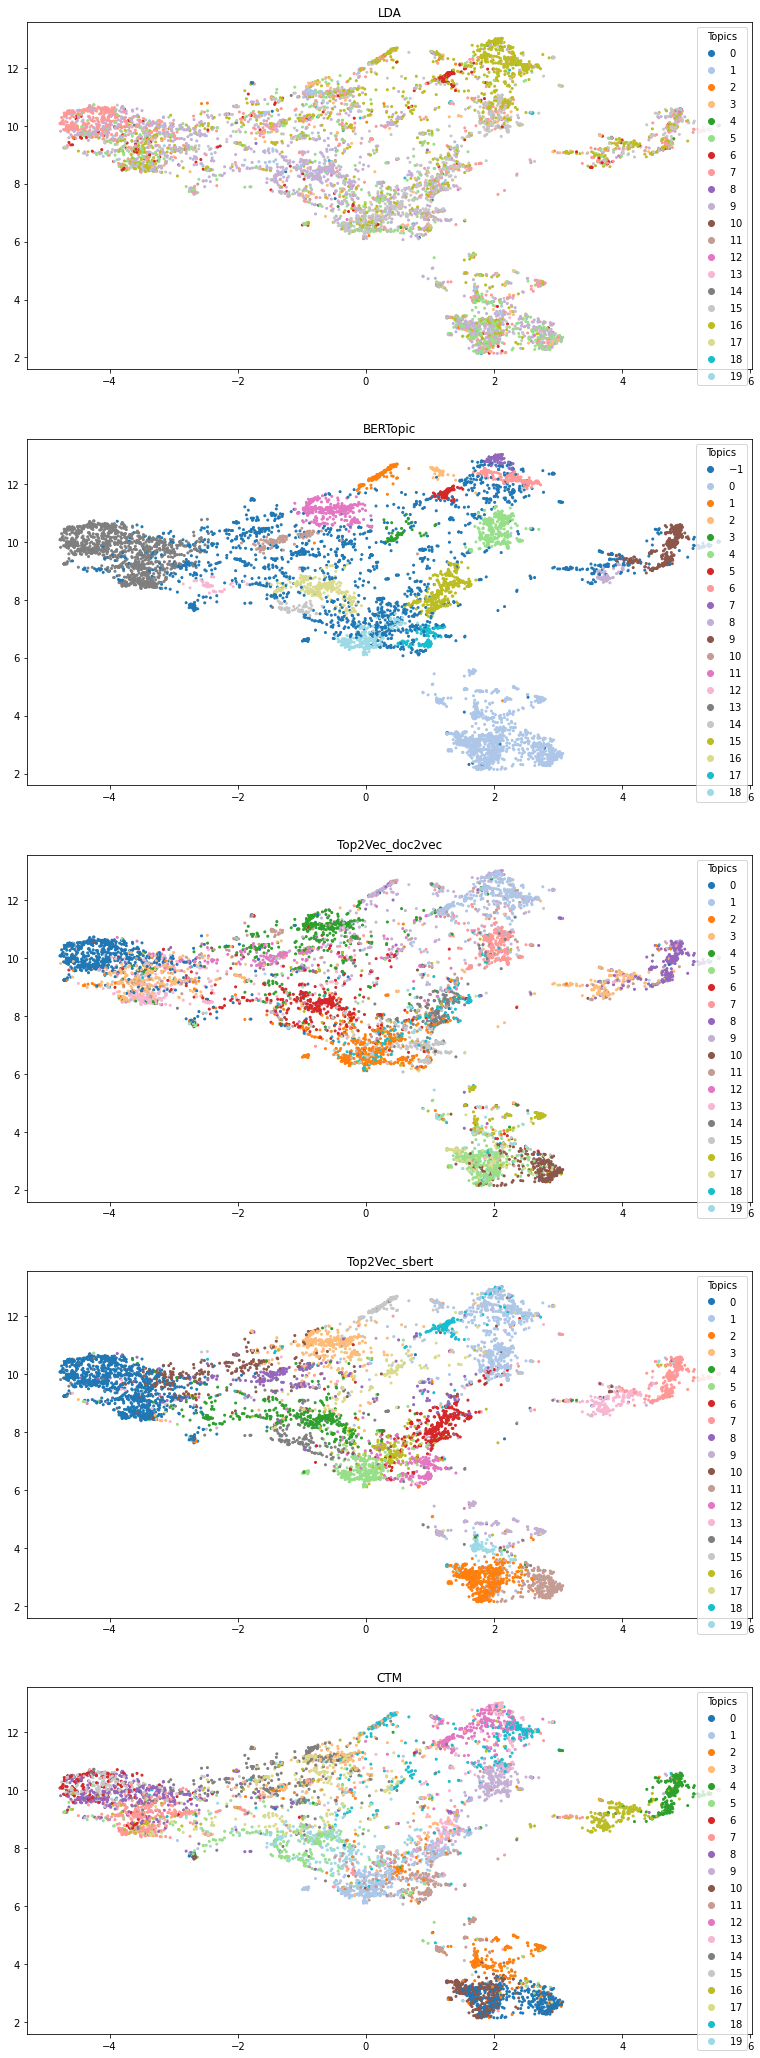

In [21]:
# Plot the 2D UMAP projection with the topic labels
labels = [i[0] for i in topic_scores.items()]
fig, axes = plt.subplots(len(labels), 1, figsize=(13, 37))
for ax, tm in zip(axes.flatten(), labels):
    ax.set_title(tm)
    scatter = ax.scatter(umap_emb[:, 0], umap_emb[:, 1], s=4, c=doc_topics[tm], cmap='tab20')
    ax.legend(*scatter.legend_elements(num=20), loc="upper right", title="Topics")

fig.savefig(os.path.join(out_path, 'umap_topics.png'))
fig.show()